#Project 3
##Mansi Upadhyay- 002766397

###Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io

pd.set_option("display.max_colwidth", None)

from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix


from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:


!pip install nltk
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

!pip install nltk
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###LOADING DATA

In [ ]:

df_ = pd.read_csv("/content/sample_data/spam.csv", encoding="latin-1", usecols=["v1", "v2"])
df = df_.copy()
df.columns = ["label", "text"]
df = df[["text", "label"]]
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()



,text,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0


In [ ]:


def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    #bold(" DESCRIBE ".center(50, "#"))
    #print(data.describe().T)
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))

In [ ]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 5572
COLS: 2


**##################### TYPES ######################**

text     object
label     int64
dtype: object


**################# MISSING VALUES #################**

text     0
label    0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 403


**################## MEMORY USAGE ##################**

Memory Usage: 87.2+ KB


In [ ]:

df = df.drop_duplicates()

###EXPLORATORY DATA ANALYSIS

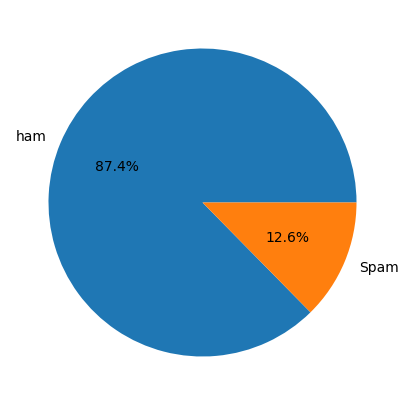

In [ ]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["ham", "Spam"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

In [ ]:
#analysing the fequency of words using word_freq
def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

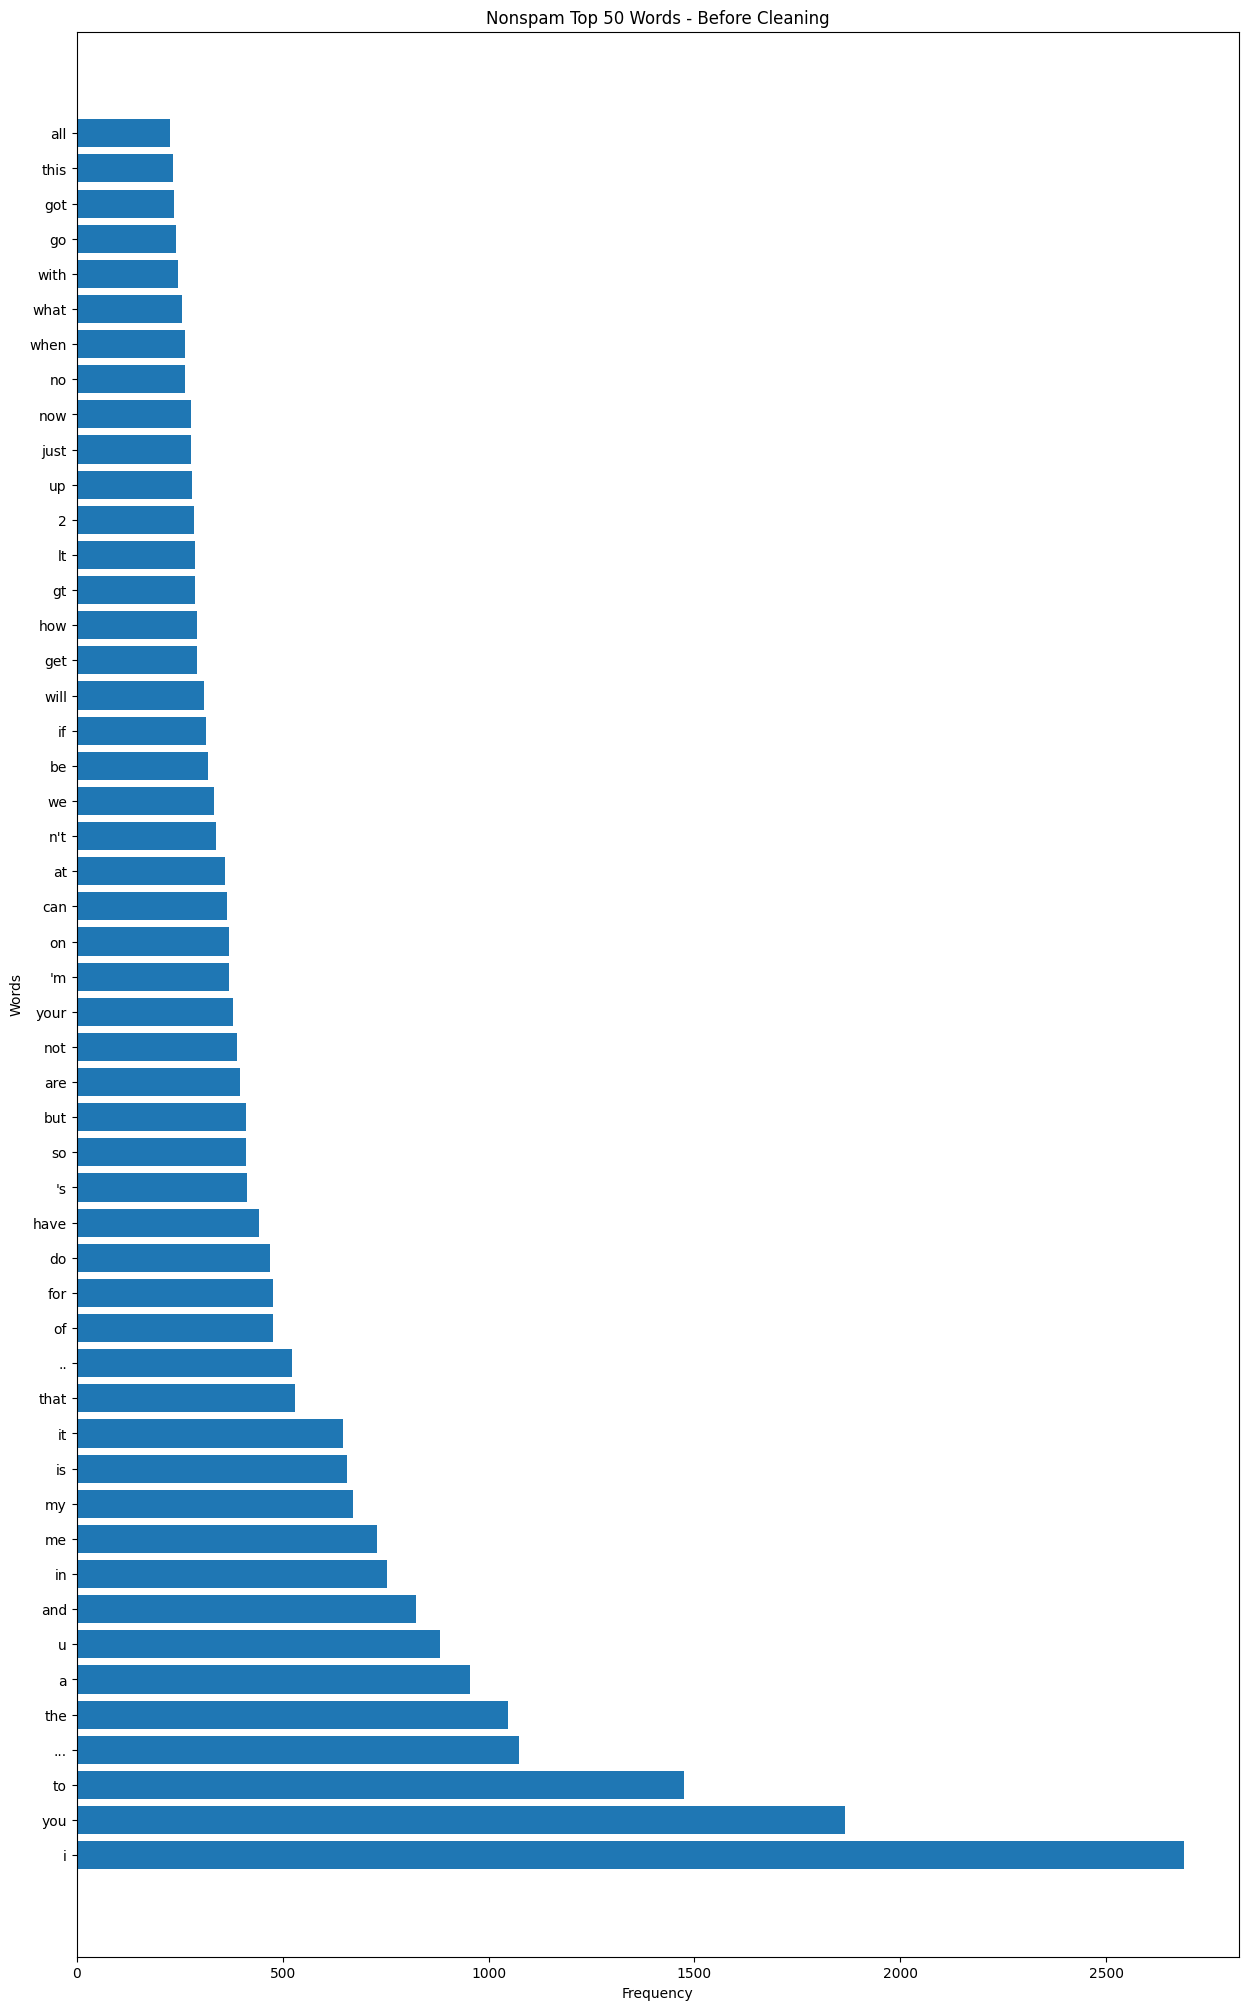

In [ ]:
ham_freq_top = word_freq(df, 0, "text", "Nonspam Top 50 Words - Before Cleaning")

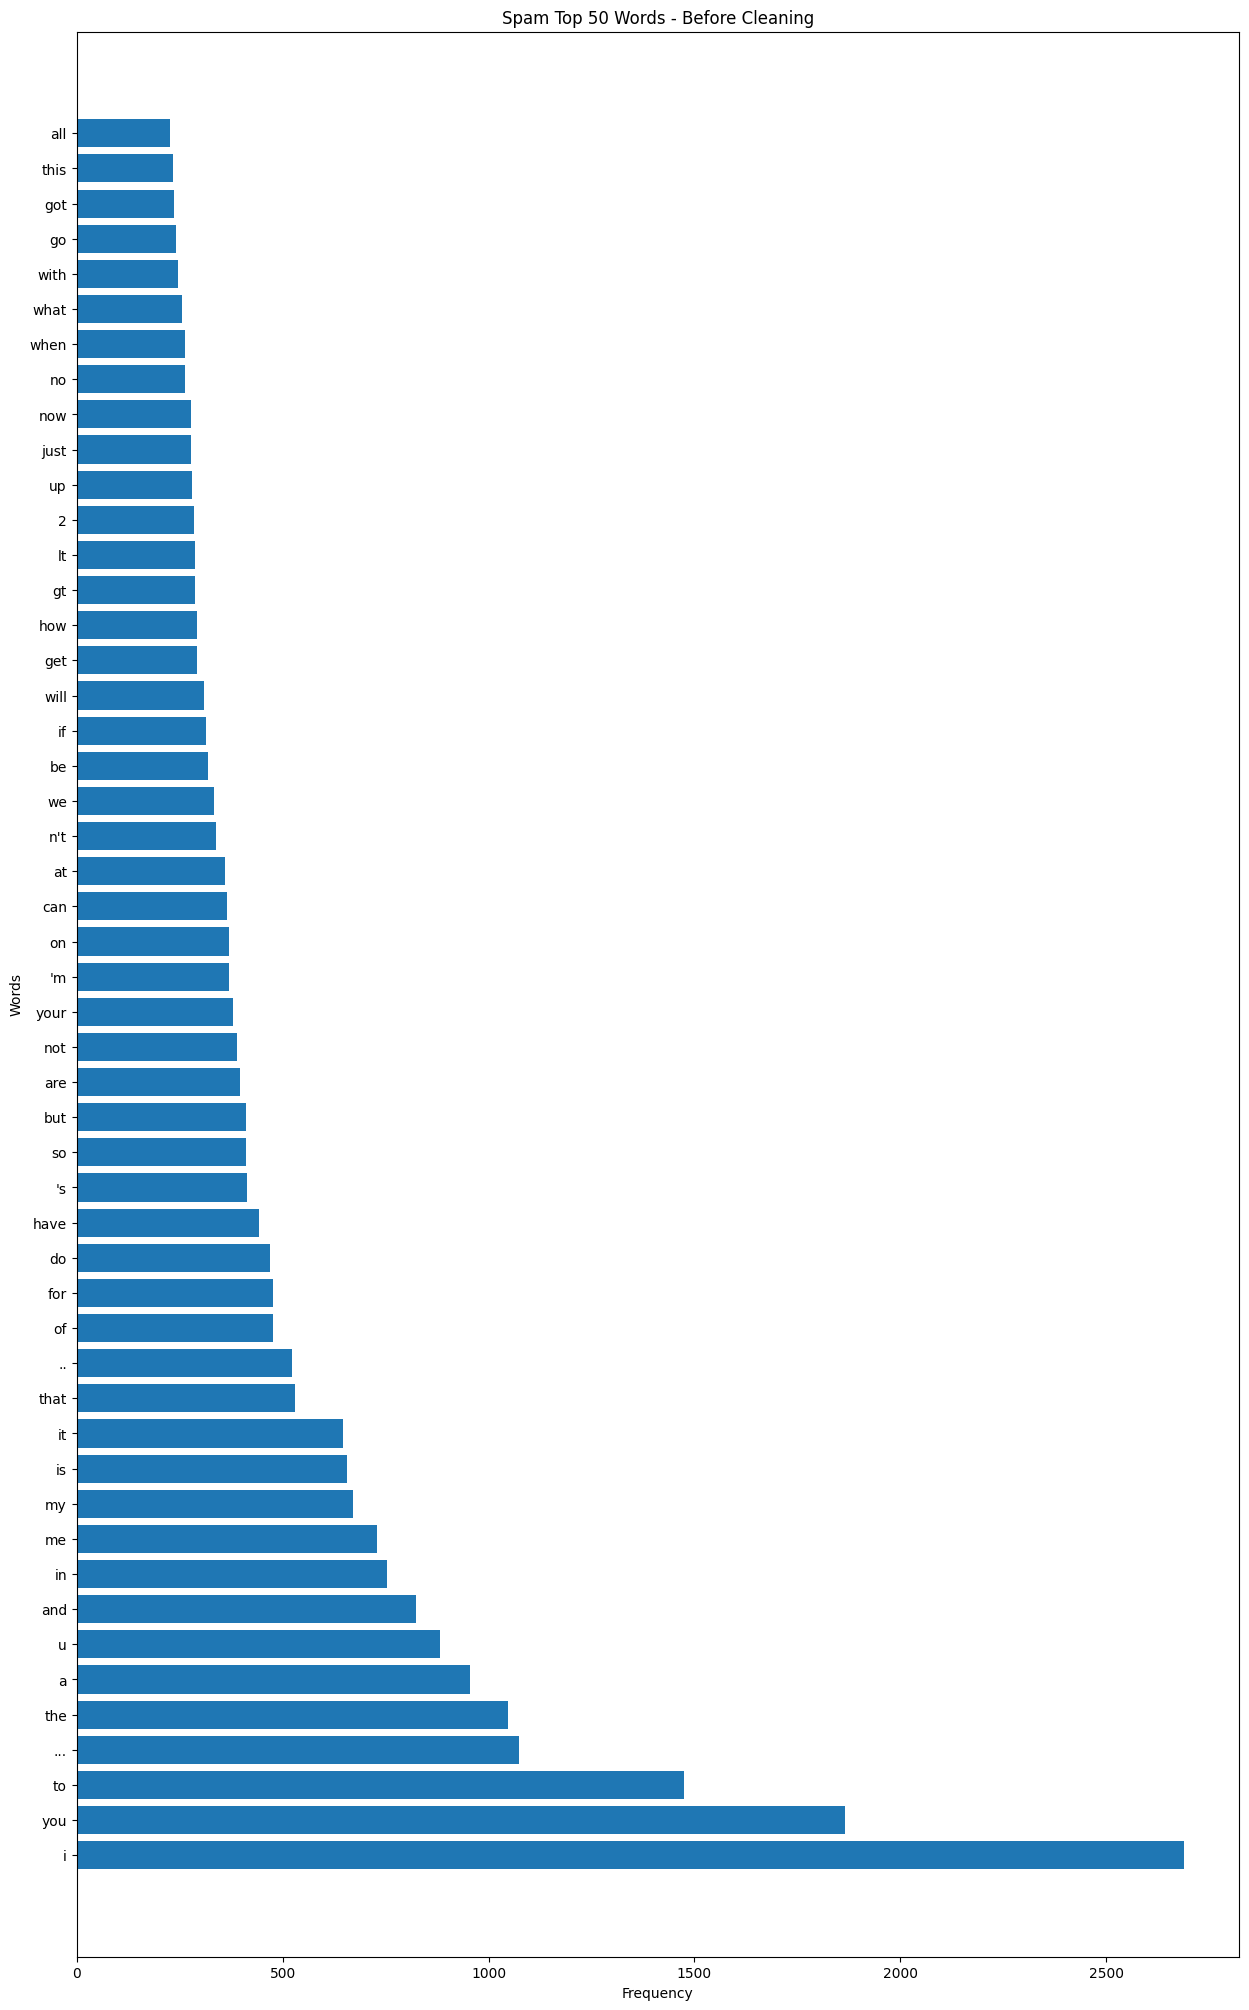

In [ ]:
spam_freq_top = word_freq(df, 0, "text", "Spam Top 50 Words - Before Cleaning")

In [ ]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

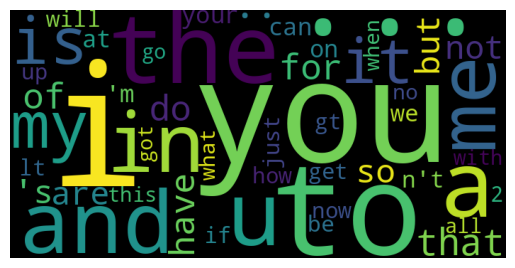

In [ ]:
print_wordcloud(ham_freq_top)

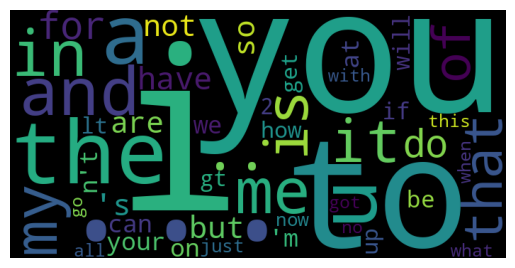

In [ ]:
print_wordcloud(spam_freq_top)

###PRE-PROCESSING DATA

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
smart_words = "/content/sample_data/SmartStoplist.txt"

In [ ]:
smart_stoplist = []

In [ ]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [ ]:
smart_stoplist

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

In [ ]:
smart_stoplist.append("_")

In [ ]:
import nltk

# Download 'stopwords' resource explicitly
nltk.download('stopwords')

# Set NLTK data path explicitly in Colab
nltk.data.path.append("/root/nltk_data/")

# Now, try to list the contents of the NLTK data directory
!ls -l /root/nltk_data/


total 8
drwxr-xr-x 3 root root 4096 Nov 25 17:09 corpora
drwxr-xr-x 3 root root 4096 Nov 25 17:09 tokenizers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#nltk.download("all")
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


cp: cannot stat '/usr/share/nltk_data/corpora/wordnet2022': No such file or directory


In [ ]:
df["clean"] = df["text"].apply(clean)

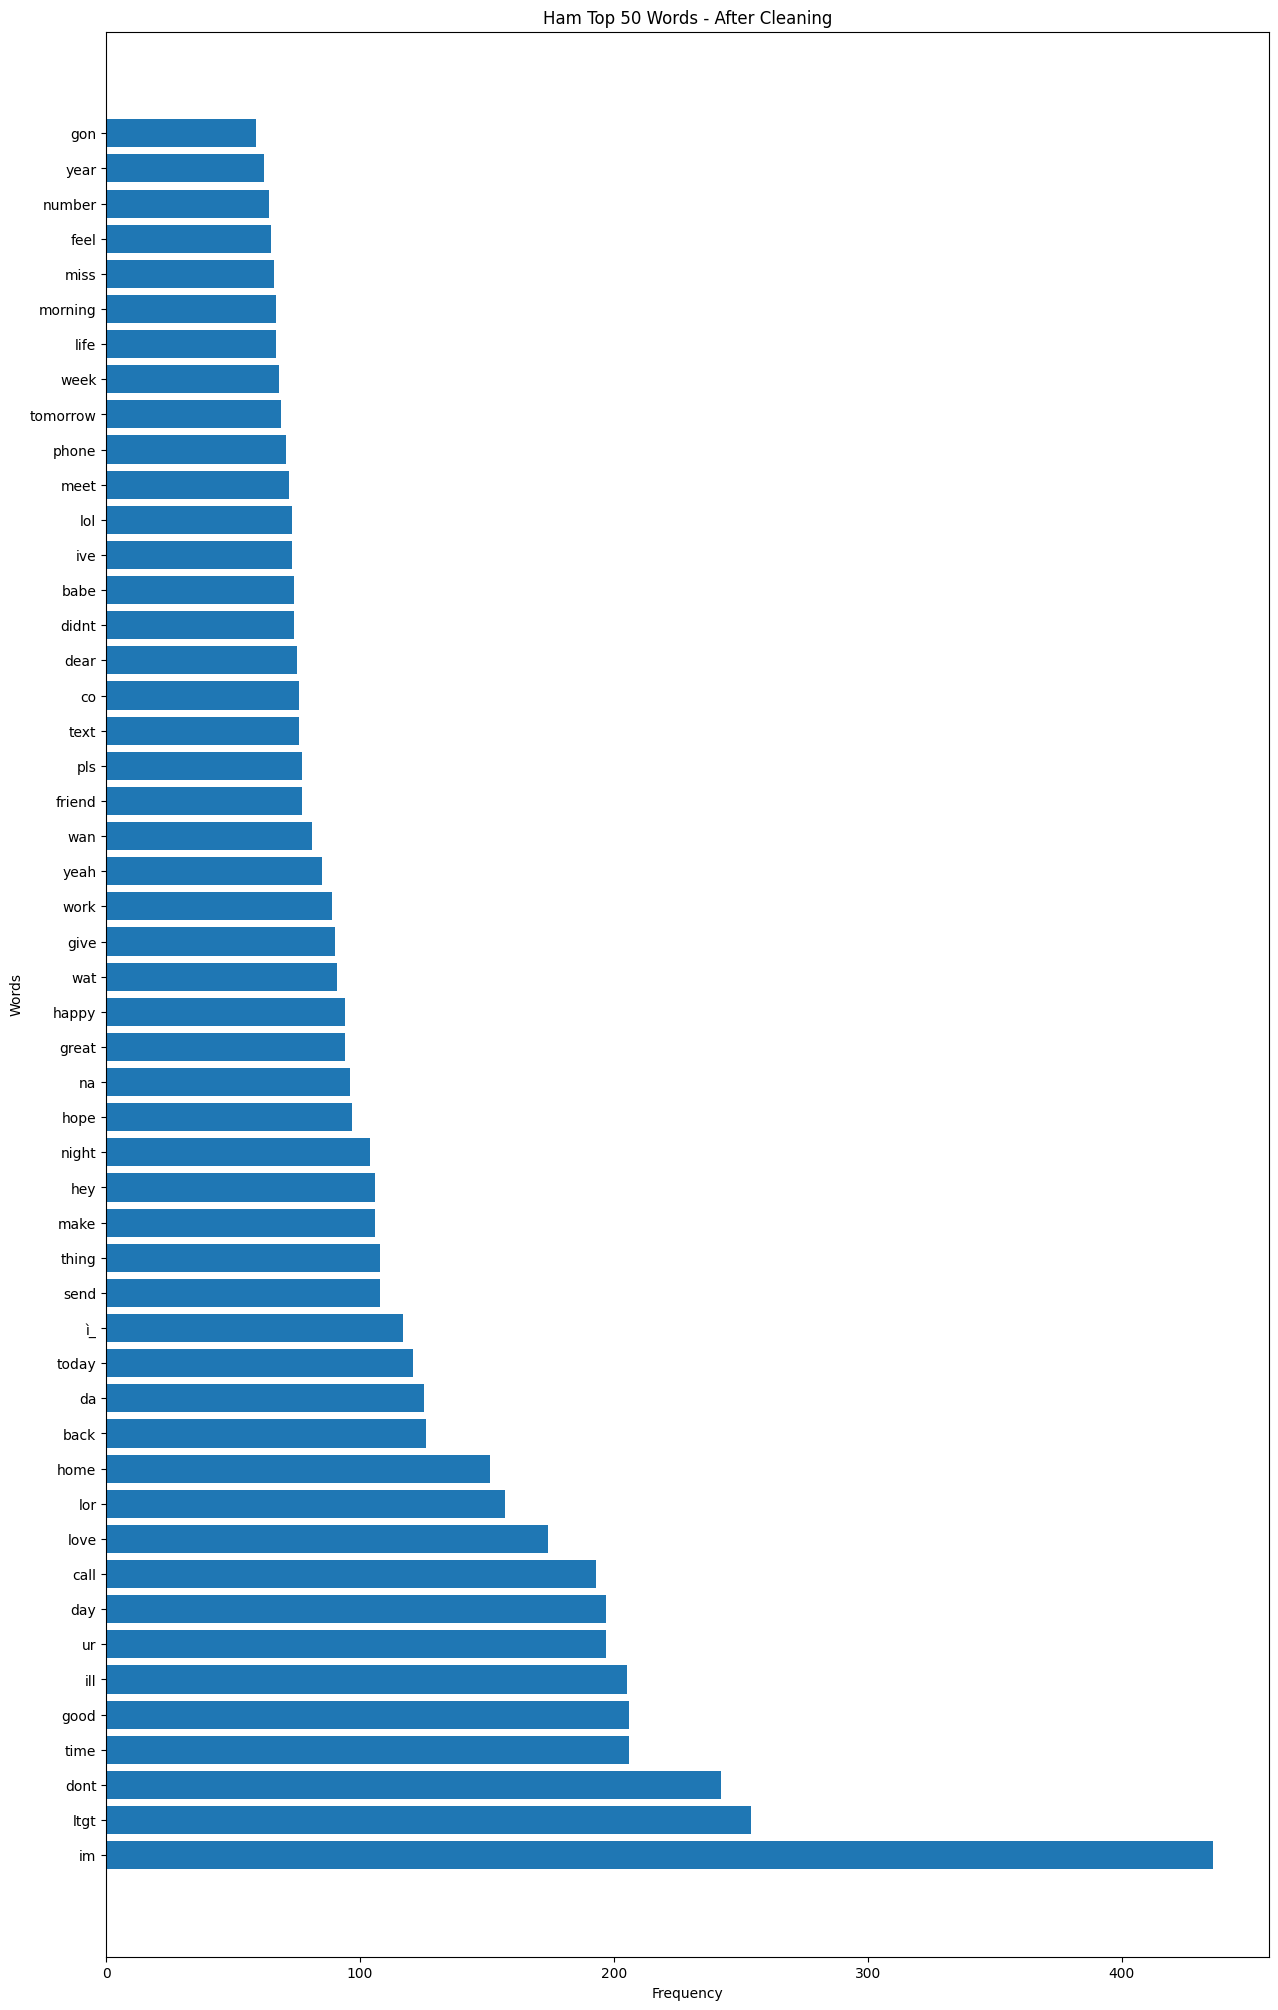

In [ ]:
clean_ham_freq_top = word_freq(df, 0, "clean", "Ham Top 50 Words - After Cleaning")

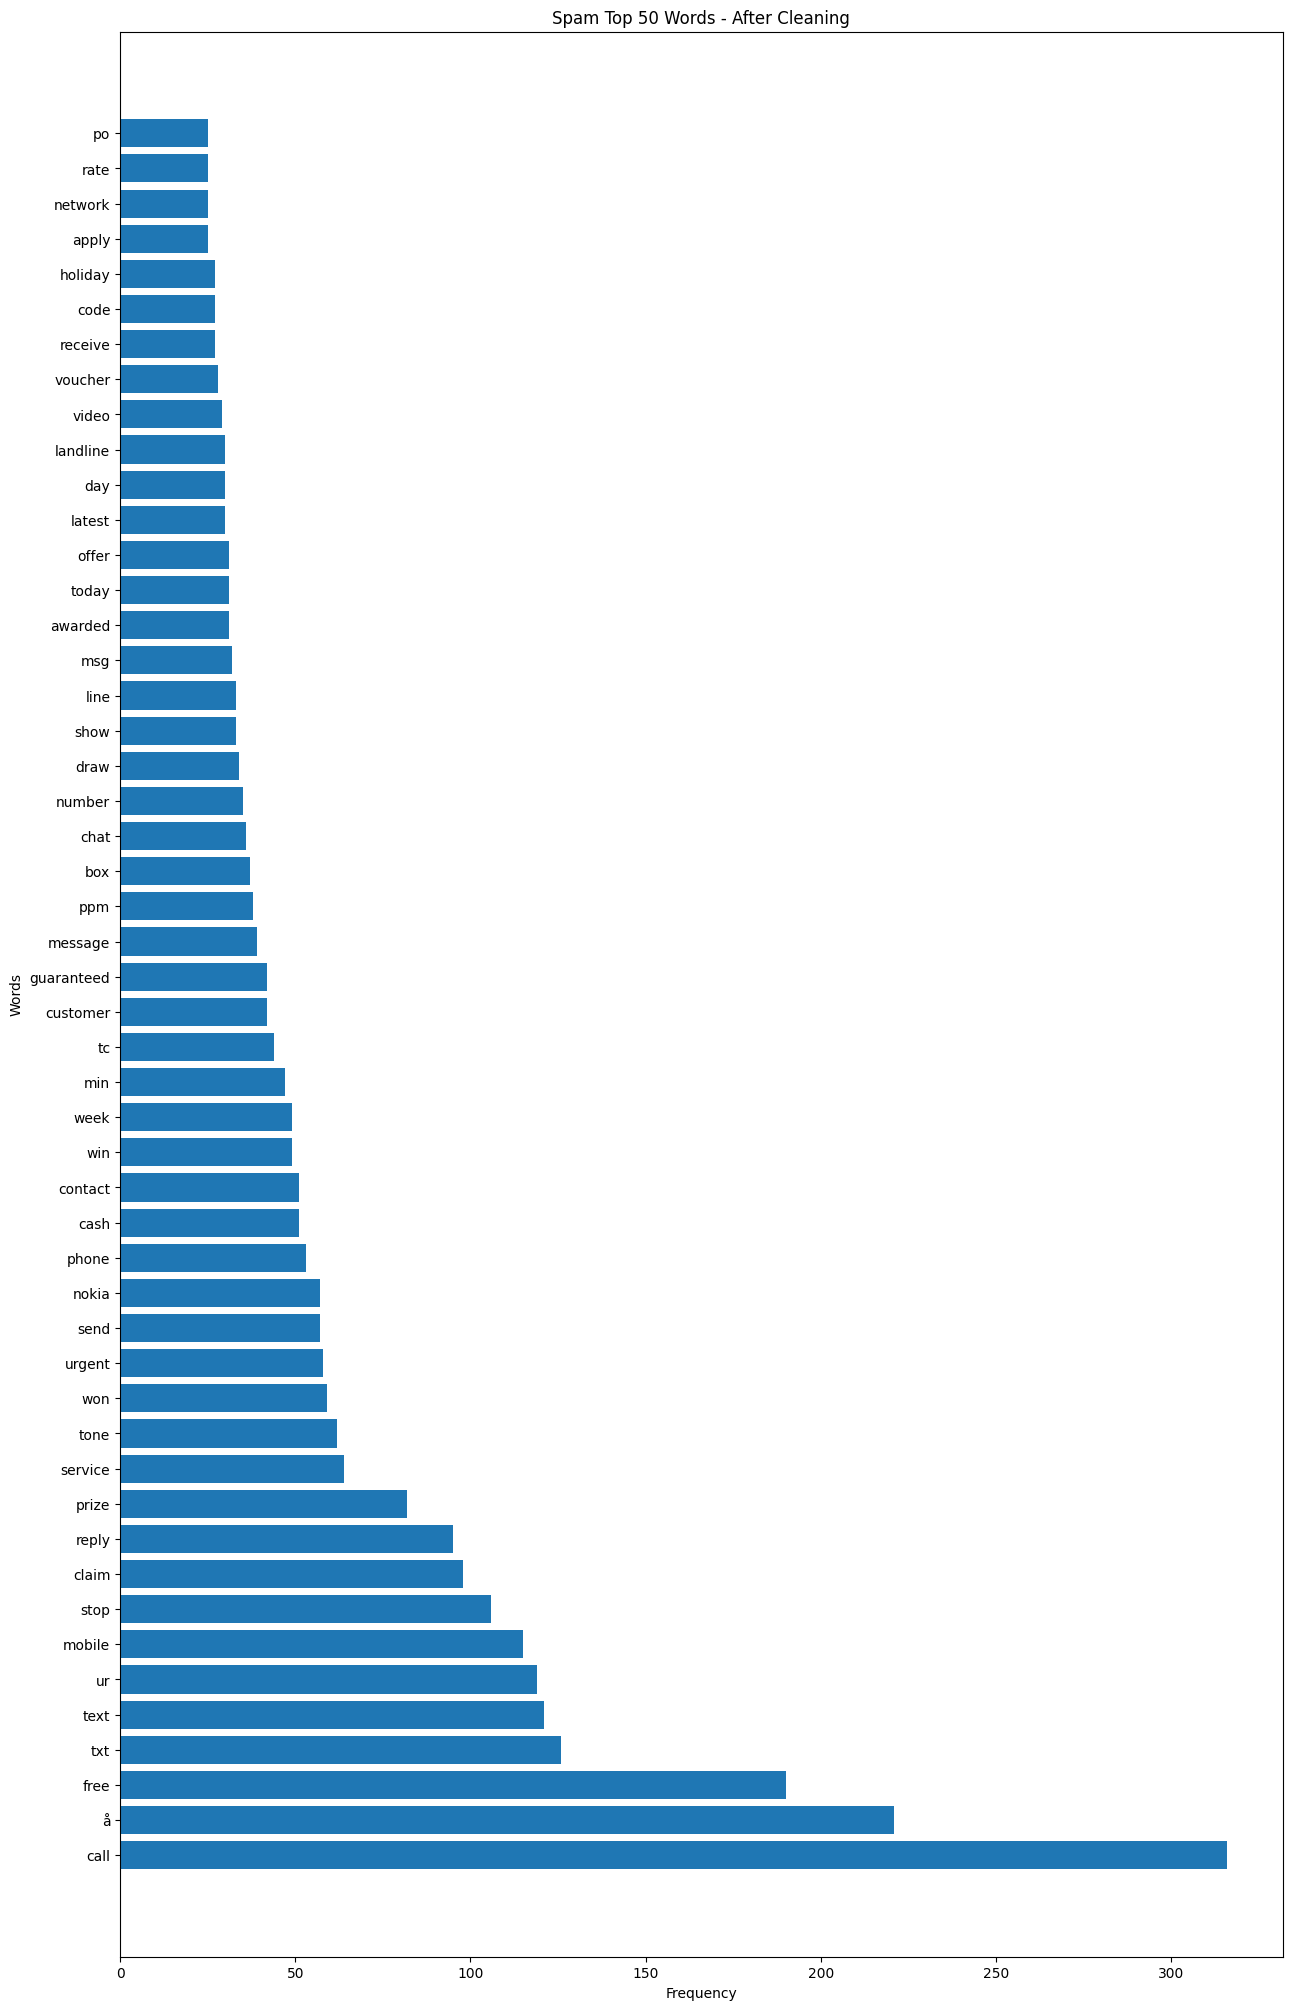

In [ ]:
clean_spam_freq_top = word_freq(df, 1, "clean", "Spam Top 50 Words - After Cleaning")

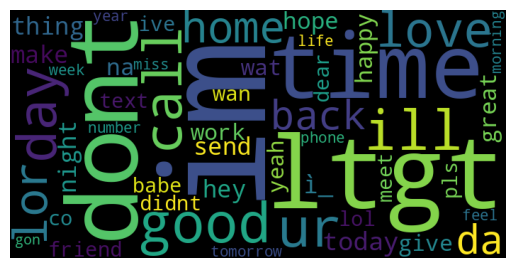

In [ ]:
print_wordcloud(clean_ham_freq_top)

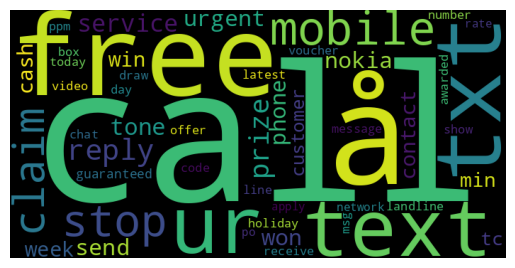

In [ ]:
print_wordcloud(clean_spam_freq_top)

###FEATURE SCALING



In [ ]:
X = df["clean"]
y = df["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
maxlen = 70

In [ ]:
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [ ]:
word_index = tokenizer.word_index
len(word_index)

7643

In [ ]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [ ]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [ ]:
!pip install --upgrade kaggle

In [ ]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d takuok/glove840b300dtxt -f glove.840B.300d.txt --force



100% 2.07G/2.08G [00:35<00:00, 65.5MB/s]
100% 2.08G/2.08G [00:35<00:00, 63.4MB/s]


In [ ]:
import zipfile
import numpy as np
import tqdm

# Path to the zip file
zip_file_path = "/content/glove.840B.300d.txt.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Path to the extracted text file
text_file_path = "/content/glove.840B.300d.txt"

# Load embeddings from the text file
embeddings_index = {}
with open(text_file_path, "r", encoding="utf-8") as f:
    for line in tqdm.tqdm(f):
        values = line.split(" ")
        word = values[0]
        coefs = np.asarray([float(val) for val in values[1:]])
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


2196018it [02:34, 14197.70it/s]

Found 2196017 word vectors.


In [ ]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 7643/7643 [00:00<00:00, 233727.04it/s]


###IMPLEMENTING MODELS

Naive Bayes

In [ ]:
# Train Multinomial Naive Bayes
mnb = MultinomialNB()
mnb_tfidf_train_start = time.time()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_train_end = time.time()
mnb_tfidf_train_time = mnb_tfidf_train_end - mnb_tfidf_train_start
print("TF-IDF + Multinomial Naive Bayes Train Time =", mnb_tfidf_train_time)

TF-IDF + Multinomial Naive Bayes Train Time = 0.005732297897338867


In [ ]:
# Predictions on training and testing sets
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)

# Test time
mnb_tfidf_test_start = time.time()
mnb_tfidf_test_end = time.time()
mnb_tfidf_test_time = mnb_tfidf_test_end - mnb_tfidf_test_start

In [ ]:
# Evaluation Metrics
mnb_tfidf_train_score = accuracy_score(mnb_tfidf_pred_train, y_train)
mnb_tfidf_test_score = accuracy_score(mnb_tfidf_pred_test, y_test)

print(f"TF-IDF + Multinomial Naive Bayes Train Score: {mnb_tfidf_train_score * 100:.2f}%")
print(f"TF-IDF + Multinomial Naive Bayes Test Score: {mnb_tfidf_test_score * 100:.2f}%")
print("TF-IDF + Multinomial Naive Bayes Test Time:", mnb_tfidf_test_time)

TF-IDF + Multinomial Naive Bayes Train Score: 97.07%
TF-IDF + Multinomial Naive Bayes Test Score: 95.84%
TF-IDF + Multinomial Naive Bayes Test Time: 4.076957702636719e-05


In [ ]:

# Precision, Recall, F1, and Accuracy Scores
mnb_tfidf_precision_score = precision_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_recall_score = recall_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_f1_score = f1_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_accuracy_score = accuracy_score(y_test, mnb_tfidf_pred_test)

print(f"TF-IDF + Multinomial Naive Bayes Precision Score: {mnb_tfidf_precision_score * 100:.2f}%")
print(f"TF-IDF + Multinomial Naive Bayes Recall Score: {mnb_tfidf_recall_score * 100:.2f}%")
print(f"TF-IDF + Multinomial Naive Bayes F1 Score: {mnb_tfidf_f1_score * 100:.2f}%")
print(f"TF-IDF + Multinomial Naive Bayes Accuracy Score: {mnb_tfidf_accuracy_score * 100:.2f}%")

TF-IDF + Multinomial Naive Bayes Precision Score: 100.00%
TF-IDF + Multinomial Naive Bayes Recall Score: 70.34%
TF-IDF + Multinomial Naive Bayes F1 Score: 82.59%
TF-IDF + Multinomial Naive Bayes Accuracy Score: 95.84%


              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       889
        spam       1.00      0.70      0.83       145

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034



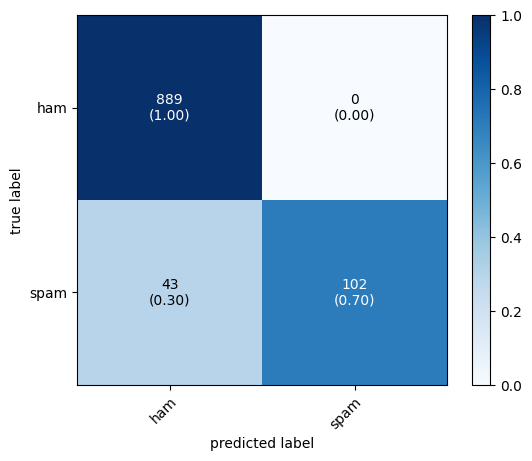

In [ ]:
# Classification Report
print(classification_report(y_test, mnb_tfidf_pred_test, target_names=["ham", "spam"]))

# Confusion Matrix
mnb_tfidf_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

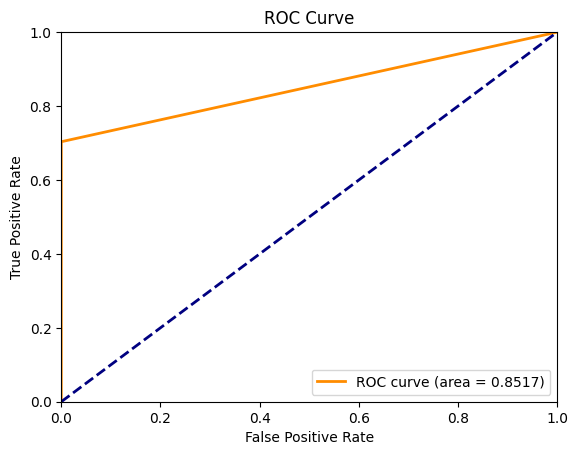

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, mnb_tfidf_pred_test)
mnb_tfidf_roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_tfidf_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

SimpleRNN

In [ ]:
simplernn = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    SimpleRNN(100),
    Dense(1, activation='sigmoid')
])

simplernn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

simplernn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 32)            244608    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               13300     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 258009 (1007.85 KB)
Trainable params: 258009 (1007.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:


model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model1_train_end = time.time()
model1_train_time = model1_train_end - model1_train_start
print("Model1 Train Time = ", model1_train_time)

Epoch 1/5
59/59 [==============================] - 3s 23ms/step - loss: 0.3947 - accuracy: 0.8543 - val_loss: 0.2265 - val_accuracy: 0.9130
Epoch 2/5
59/59 [==============================] - 1s 19ms/step - loss: 0.1669 - accuracy: 0.9387 - val_loss: 0.0738 - val_accuracy: 0.9831
Epoch 3/5
59/59 [==============================] - 1s 19ms/step - loss: 0.0579 - accuracy: 0.9828 - val_loss: 0.0532 - val_accuracy: 0.9831
Epoch 4/5
59/59 [==============================] - 1s 19ms/step - loss: 0.0349 - accuracy: 0.9898 - val_loss: 0.0475 - val_accuracy: 0.9831
Epoch 5/5
59/59 [==============================] - 1s 19ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.2418 - val_accuracy: 0.9179
Model1 Train Time =  11.741673469543457


In [ ]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_end = time.time()
model1_test_time = model1_test_end - model1_test_start
print("Model1 Test Time = ", model1_test_time)

33/33 [==============================] - 0s 5ms/step
Model1 Test Time =  0.49727940559387207


In [ ]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.2f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.2f}%")

130/130 [==============================] - 1s 4ms/step
SimpleRNN Train Score = 98.14%
SimpleRNN Test Score = 93.13%


In [ ]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.2f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.2f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.2f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.2f}%")

SimpleRNN Precision Score = 67.96%
SimpleRNN F1 Score = 79.77%
SimpleRNN Recall Score = 96.55%
SimpleRNN Accuracy Score = 93.13%


In [ ]:
print(classification_report(y_test, simplernn_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.93      0.96       889
        spam       0.68      0.97      0.80       145

    accuracy                           0.93      1034
   macro avg       0.84      0.95      0.88      1034
weighted avg       0.95      0.93      0.94      1034



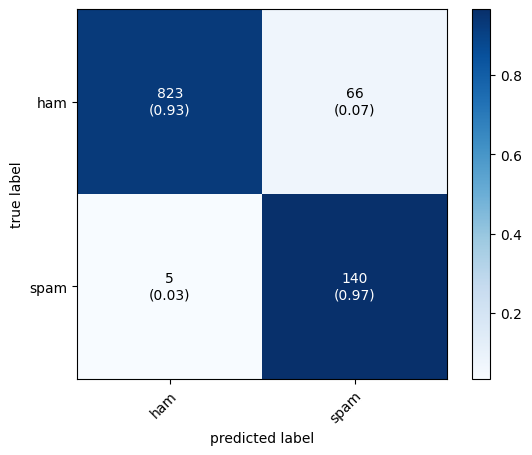

In [ ]:
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

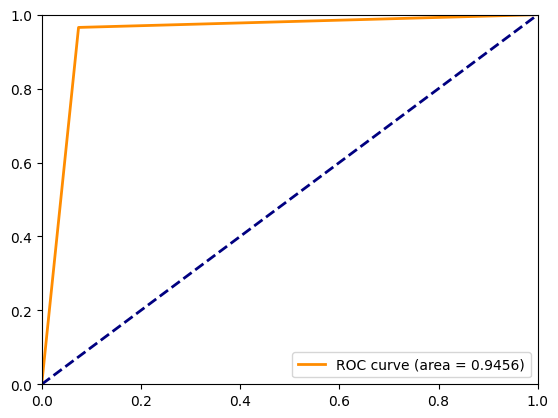

In [ ]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {simplernn_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

LSTM- Long short-term memory

In [ ]:
lstm = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 32)            244608    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 297909 (1.14 MB)
Trainable params: 297909 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model2_train_end = time.time()
model2_train_time = model2_train_end - model2_train_start
print("Model2 Train Time = ", model2_train_time)

Epoch 1/5
59/59 [==============================] - 6s 72ms/step - loss: 0.3630 - accuracy: 0.8780 - val_loss: 0.1376 - val_accuracy: 0.9565
Epoch 2/5
59/59 [==============================] - 5s 78ms/step - loss: 0.1027 - accuracy: 0.9737 - val_loss: 0.0431 - val_accuracy: 0.9855
Epoch 3/5
59/59 [==============================] - 4s 60ms/step - loss: 0.0469 - accuracy: 0.9871 - val_loss: 0.0452 - val_accuracy: 0.9879
Epoch 4/5
59/59 [==============================] - 4s 60ms/step - loss: 0.0228 - accuracy: 0.9925 - val_loss: 0.0486 - val_accuracy: 0.9783
Epoch 5/5
59/59 [==============================] - 4s 66ms/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0979 - val_accuracy: 0.9589
Model2 Train Time =  22.156057357788086


In [ ]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_end = time.time()
model2_test_time = model2_test_end - model2_test_start
print("Model2 Test Time = ", model2_test_time)

33/33 [==============================] - 1s 12ms/step
Model2 Test Time =  0.8527894020080566


In [ ]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.2f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.2f}%")

130/130 [==============================] - 1s 10ms/step
LSTM Train Score = 99.30%
LSTM Test Score = 97.20%


In [ ]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.2f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.2f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.2f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.2f}%")

LSTM Precision Score = 87.66%
LSTM F1 Score = 90.30%
LSTM Recall Score = 93.10%
LSTM Accuracy Score = 97.20%


In [ ]:
print(classification_report(y_test, lstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       889
        spam       0.88      0.93      0.90       145

    accuracy                           0.97      1034
   macro avg       0.93      0.95      0.94      1034
weighted avg       0.97      0.97      0.97      1034



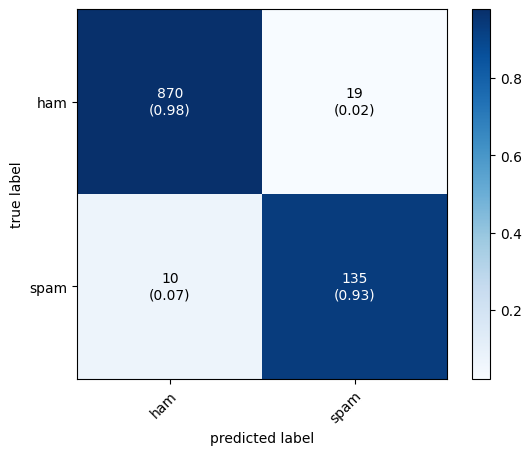

In [ ]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

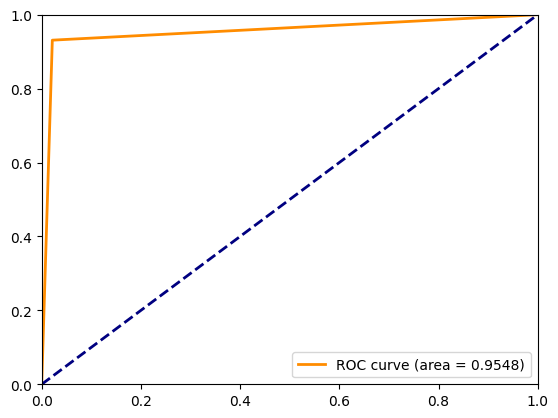

In [ ]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

GRU

In [ ]:
gru = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    GRU(100),
    Dense(1, activation='sigmoid')
])

gru.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 70, 32)            244608    
                                                                 
 gru_1 (GRU)                 (None, 100)               40200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 284909 (1.09 MB)
Trainable params: 284909 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model3_train_end = time.time()
model3_train_time = model3_train_end - model3_train_start
print("Model3 Train Time = ", model3_train_time)

Epoch 1/5
59/59 [==============================] - 9s 129ms/step - loss: 0.3469 - accuracy: 0.8793 - val_loss: 0.0965 - val_accuracy: 0.9807
Epoch 2/5
59/59 [==============================] - 9s 159ms/step - loss: 0.0808 - accuracy: 0.9823 - val_loss: 0.0413 - val_accuracy: 0.9855
Epoch 3/5
59/59 [==============================] - 6s 103ms/step - loss: 0.0347 - accuracy: 0.9901 - val_loss: 0.0477 - val_accuracy: 0.9831
Epoch 4/5
59/59 [==============================] - 4s 65ms/step - loss: 0.0156 - accuracy: 0.9960 - val_loss: 0.0522 - val_accuracy: 0.9807
Epoch 5/5
59/59 [==============================] - 5s 79ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.0850 - val_accuracy: 0.9638
Model3 Train Time =  42.652631998062134


In [ ]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_end = time.time()
model3_test_time = model3_test_end - model3_test_start
print("Model3 Test Time = ", model3_test_time)

33/33 [==============================] - 1s 9ms/step
Model3 Test Time =  0.9039382934570312


In [ ]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [1 if i > 0.5 else 0 for i in gru_pred_train]
gru_pred_test = [1 if i > 0.5 else 0 for i in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.2f}%")
print(f"GRU Test Score = {gru_test_score * 100:.2f}%")

130/130 [==============================] - 1s 9ms/step
GRU Train Score = 99.54%
GRU Test Score = 97.10%


In [ ]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.2f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.2f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.2f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.2f}%")

GRU Precision Score = 87.10%
GRU F1 Score = 90.00%
GRU Recall Score = 93.10%
GRU Accuracy Score = 97.10%


In [ ]:
print(classification_report(y_test, gru_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       889
        spam       0.87      0.93      0.90       145

    accuracy                           0.97      1034
   macro avg       0.93      0.95      0.94      1034
weighted avg       0.97      0.97      0.97      1034



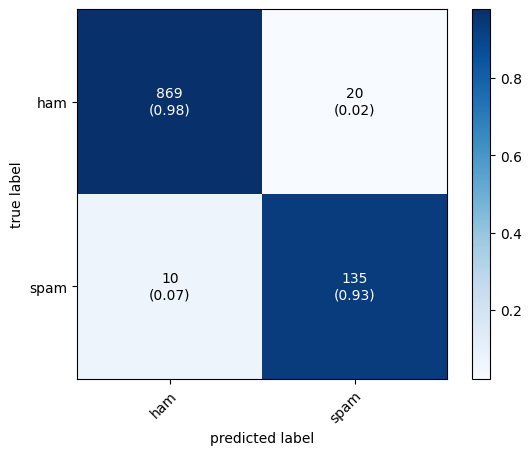

In [ ]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

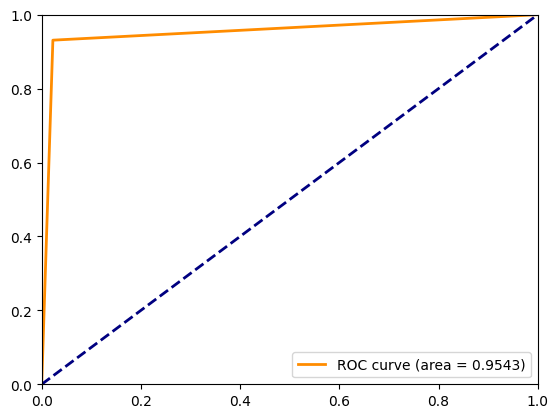

In [ ]:
fpr, tpr, _ = roc_curve(y_test, gru_pred_test)
gru_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [ ]:


scores_df = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Score", "Test Score",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [ ]:

scores_df.loc[1] = ["MultinomialNB + TF-IDF",
                    mnb_tfidf_train_time,
                    mnb_tfidf_test_time,
                    mnb_tfidf_train_score,
                    mnb_tfidf_test_score,
                    mnb_tfidf_accuracy_score,
                    mnb_tfidf_f1_score,
                    mnb_tfidf_precision_score,
                    mnb_tfidf_recall_score,
                    mnb_tfidf_roc_auc]

In [ ]:
scores_df.loc[2] = ["SimpleRNN + GloVe",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [ ]:
scores_df.loc[3] = ["LSTM + GloVe",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [ ]:
scores_df.loc[4] = ["GRU + GloVe",
                    model3_train_time,
                    model3_test_time,
                    gru_train_score,
                    gru_test_score,
                    gru_accuracy_score,
                    gru_f1_score,
                    gru_precision_score,
                    gru_recall_score,
                    gru_roc_auc]

In [ ]:
scores_df

,Model Name,Train Time,Test Time,Train Score,Test Score,Accuracy,F1,Precision,Recall,ROC-AUC
1,MultinomialNB + TF-IDF,0.005732,0.000041,0.970738,0.958414,0.958414,0.825911,1.000000,0.703448,0.851724
2,SimpleRNN + GloVe,11.741673,0.497279,0.981378,0.931335,0.931335,0.797721,0.679612,0.965517,0.945638
3,LSTM + GloVe,22.156057,0.852789,0.992987,0.971954,0.971954,0.903010,0.876623,0.931034,0.954831
4,GRU + GloVe,42.652632,0.903938,0.995405,0.970986,0.970986,0.900000,0.870968,0.931034,0.954269


*LSTM + GloVe model is considered the best-performing among the presented models:*

Accuracy and Generalization:

The LSTM + GloVe model achieved the highest test accuracy (97.20%). High accuracy indicates that the model performed well on unseen data, suggesting good generalization.
F1 Score - Balance of Precision and Recall:

The F1 score of 90.30% for LSTM + GloVe is the highest among the models. F1 score considers both precision and recall, and a high F1 score indicates a balance between correctly identifying positive instances (precision) and capturing all positive instances (recall).
Robustness and Discrimination:

The ROC-AUC score of 95.48% for LSTM + GloVe indicates that the model is effective at distinguishing between spam and non-spam messages. A high ROC-AUC suggests that the model can discriminate between classes well, even when the class distribution is imbalanced.
Sequential Learning with LSTM:

Long Short-Term Memory (LSTM) networks are well-suited for sequential data like text. They can capture dependencies and patterns in the sequence of words, allowing the model to understand the context and relationships within the text data.
GloVe Embeddings - Semantic Understanding:

The use of pre-trained GloVe embeddings provides the model with a rich representation of words based on their semantic meanings. This helps the model understand the nuanced relationships between words, contributing to better feature representations.
Balanced Precision and Recall:

Precision and recall are well-balanced in the LSTM + GloVe model, as indicated by precision (87.66%) and recall (93.10%). This balance is crucial for a spam detection system, as it minimizes both false positives and false negatives.
Consistent Performance Across Metrics:

The LSTM + GloVe model consistently performs well across various metrics, indicating its robustness and effectiveness in classifying spam and non-spam messages.

**Multinomial Naive Bayes (MNB) + TF-IDF:**

**Strengths:**

Simple and computationally efficient.

Works well with a large number of features.

**Possible Limitations:**

Naive Bayes assumes independence between features, which might not hold well for the complex relationships in text data.

Might not capture sequential dependencies in the text, which is crucial for understanding the context of messages.

**SimpleRNN + GloVe:**

**Strengths:**

Simplicity and interpretability.

Captures sequential patterns in data.

**Possible Limitations:**

Struggles with capturing long-term dependencies in sequences, which is essential for understanding the context in lengthy text messages.

Prone to vanishing gradient problems, limiting its ability to retain information over long sequences.

**GRU + GloVe:**

**Strengths:**

Improved handling of long-term dependencies compared to SimpleRNN.

**Possible Limitations:**

Might still face challenges in capturing very long-term dependencies.

LSTM is often preferred over GRU for tasks that require modeling complex sequential dependencies.

